In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import statsmodels.api as sm

from src.dynamic_pricing_data_loader import cargar_y_preparar_datos

In [2]:
def GetData():
    # Se definen las rutas de los archivos de configuración y datos.
    ruta_principal = os.getcwd()
    config_path = os.path.join(ruta_principal, "config", "config.json")
    
    # Se cargan y preparan los datos usando una función externa.
    Frame = cargar_y_preparar_datos(config_path, ruta_principal)
    
    Df = Frame[['NOMBRE_PASAJERO','BOLETOS_VEND', 'CLASE_SERVICIO', 'DESC_DESCUENTO', 'DIAS_ANTICIPACION',
                'EMAIL', 'FECHA_CORRIDA', 'FECHA_OPERACION', 'HORAS_ANTICIPACION',
                  'PAGO_METODO', 'PORCENT_PROMO',
                'TIPO_CORRIDA', 'TIPO_PASAJERO',  'TOTAL_BOLETOS',
                'VENTA', 'VENTA_ANTICIPADA', 'VENTA_TOTAL']]
    
    Df=Df[Df[ 'VENTA_TOTAL']>0]
    Df=Df[Df[ 'BOLETOS_VEND']>0]
    Df['HORAS_ANTICIPACION']=Df['HORAS_ANTICIPACION'].abs()
    Df['DIAS_ANTICIPACION']=Df['DIAS_ANTICIPACION'].abs()
    Df['PORCENT_PROMO'] = Df['PORCENT_PROMO'].fillna(0)
    known = (
        Df
        .dropna(subset=['EMAIL'])
        .drop_duplicates(subset=['NOMBRE_PASAJERO'])
        [['NOMBRE_PASAJERO','EMAIL']]
    )
    Df = Df.merge(
        known,
        on='NOMBRE_PASAJERO',
        how='left',
        suffixes=('','_KNOWN')
    )
    Df['EMAIL'] = Df['EMAIL'].fillna(Df['EMAIL_KNOWN'])
    Df.drop(columns=['EMAIL_KNOWN'], inplace=True)
    
    dominio = 'ejemplo.com'
    nombres_sin_email = Df.loc[Df['EMAIL'].isna(), 'NOMBRE_PASAJERO'].unique()
    generic_map = {
        nombre: f"{nombre.lower().replace(' ','.')}@{dominio}"
        for nombre in nombres_sin_email
    }
    
    Df['EMAIL'] = Df['EMAIL'].astype('object')
    # Usamos map + fillna para poner el email genérico donde falte
    Df['EMAIL'] = Df['EMAIL'].fillna(Df['NOMBRE_PASAJERO'].map(generic_map))

    return Df

In [3]:
Df= GetData()

Memoria usada antes: 616.61 MB
Memoria usada después: 119.93 MB
Reducción: 80.6%


In [4]:
faltantes_por_columna = Df.isnull().sum()
print(faltantes_por_columna)

NOMBRE_PASAJERO       0
BOLETOS_VEND          0
CLASE_SERVICIO        0
DESC_DESCUENTO        0
DIAS_ANTICIPACION     0
EMAIL                 0
FECHA_CORRIDA         0
FECHA_OPERACION       0
HORAS_ANTICIPACION    0
PAGO_METODO           0
PORCENT_PROMO         0
TIPO_CORRIDA          0
TIPO_PASAJERO         0
TOTAL_BOLETOS         0
VENTA                 0
VENTA_ANTICIPADA      0
VENTA_TOTAL           0
dtype: int64


In [5]:
Df.loc[(Df['PORCENT_PROMO'] > 0) & (Df['DESC_DESCUENTO'] == 'ADULTO'), 'DESC_DESCUENTO'] = 'PROMOCION ESPECIAL'
Df.loc[(Df['PORCENT_PROMO'] == 0) & (Df['DESC_DESCUENTO'] == 'PROMOCION ESPECIAL'), 'DESC_DESCUENTO'] = 'ADULTO'

In [6]:
df_correo = pd.DataFrame()

In [7]:
atributo='EMAIL'
df_correo['Bol_Vend'] = Df.groupby(atributo)['BOLETOS_VEND'].sum()

In [8]:
df_correo['Prom_Pagado'] = Df.groupby(atributo)['VENTA'].mean()

In [9]:
#Df['VENTA_ANTICIPADA'] = np.where(Df['VENTA_ANTICIPADA'] == 'SI', 1, 0)

In [10]:
df_correo['%_Promo'] = Df.groupby(atributo)['PORCENT_PROMO'].mean()

In [11]:
df_correo['Prom_Horas_Ant'] = Df.groupby(atributo)['HORAS_ANTICIPACION'].mean()

In [12]:
#df_correo['Prom_Dias_Ant'] = Df.groupby(atributo)['DIAS_ANTICIPACION'].mean()

In [13]:
DESC_DESCUENTO = pd.crosstab(
    index=Df[atributo],
    columns=Df['DESC_DESCUENTO'],
    normalize='index'
)

In [14]:
#DESC_DESCUENTO['DMS']=DESC_DESCUENTO['DISCAPACIDAD']+DESC_DESCUENTO['MENOR']+DESC_DESCUENTO['SENECTUD']
#DESC_DESCUENTO['ACADEMICOS']=DESC_DESCUENTO['ESTUDIANTE']+DESC_DESCUENTO['PROFESOR']
#DESC_DESCUENTO=DESC_DESCUENTO.drop(columns=['DISCAPACIDAD','MENOR','SENECTUD','PROFESOR','ESTUDIANTE'])

In [15]:
# Reinicia el índice de DESC_DESCUENTO para convertirlo en una columna
DESC_DESCUENTO = DESC_DESCUENTO.reset_index()
#  Une los dos DataFrames en la columna 'EMAIL'
df_correo = pd.merge(
    df_correo,
    DESC_DESCUENTO,
    on='EMAIL',
    how='left'
)

In [16]:
# Opción A: Usando pd.crosstab con normalize='index'
prop_ct = pd.crosstab(
    index=Df[atributo],
    columns=Df['VENTA_ANTICIPADA'],
    normalize='index'
)

# La columna 'Si' contiene la proporción de "Si" sobre el total (Si+No)
#df_correo['Venta_A']= prop_ct['SI'].fillna(0)

In [17]:
# 1. Crea la tabla PAGO_METODO
PAGO_METODO = pd.crosstab(
    index=Df[atributo],
    columns=Df['PAGO_METODO'],
    normalize='index'
)

# 2. Reinicia el índice para convertirlo en una columna
PAGO_METODO = PAGO_METODO.reset_index()

# 3. Convierte explícitamente el tipo de dato de la columna del índice.
# Esto previene el error 'InvalidIndexError'.
PAGO_METODO[atributo] = PAGO_METODO[atributo].astype(str)

# 4. Ahora puedes unir correctamente los DataFrames
df_correo = pd.merge(
    df_correo,
    PAGO_METODO,
    on=atributo, # Asegúrate de usar el atributo correcto para unir
    how='left'
)
df_correo=df_correo.drop(columns='EFECTIVO')

In [18]:
# 1. Asegurar que FECHA_OPERACION sea datetime
Df['FECHA_OPERACION'] = pd.to_datetime(Df['FECHA_OPERACION'])

# 2. Ordenar por EMAIL y fecha de operación
Df_sorted = Df.sort_values(['EMAIL', 'FECHA_OPERACION'])

# 3. Calcular la diferencia en días entre operaciones sucesivas
Df_sorted['DIF_DIAS'] = Df_sorted.groupby('EMAIL')['FECHA_OPERACION'].diff().dt.days

# 4. Agrupar por email y calcular el promedio de esas diferencias
PP = (
    Df_sorted
    .groupby('EMAIL')['DIF_DIAS']
    .mean()
    .reset_index(name='Prom_Dias_Entre_Compra')
)

df_correo['Primer_Compra']=PP['Prom_Dias_Entre_Compra'].isna()
df_correo['Primer_Compra']=df_correo['Primer_Compra'].astype(int)
PP=PP.fillna(0)
df_correo = df_correo.merge(
    PP,
    on='EMAIL',
    how='left'
).fillna({'Prom_Dias_Entre_Compra': 0})

In [19]:
df_correo

,EMAIL,Bol_Vend,Prom_Pagado,%_Promo,Prom_Horas_Ant,ADULTO,DISCAPACIDAD,ESTUDIANTE,MENOR,PETFRIENDLY,PROFESOR,PROMOCION ESPECIAL,SENECTUD,TARJETA,Primer_Compra,Prom_Dias_Entre_Compra
0,00-MAZA.ESQUISTOSO@ICLOUD.COM,4.0,953.664978,6.25,2.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.5,0,222.0
1,000047787@LAMAR.ORG.MX,1.0,609.909973,0.00,16.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0.0
2,0019122@UP.EDU.MX,1.0,1047.410034,5.00,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1,0.0
3,0022ANDREAGONZALEZ@GMAIL.COM,2.0,504.309998,0.00,24.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,11.0
4,007ITZAMNA@GMAIL.COM,1.0,907.760010,10.00,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139224,ángel.álvarez.rodríguez@ejemplo.com,1.0,1142.500000,5.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0.0
139225,édgar.nava@ejemplo.com,1.0,985.340027,10.00,15.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0.0
139226,óscar.adrián.fonseca.ramirez@ejemplo.com,1.0,754.309998,0.00,55.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
139227,óscar.alejandro.romero@ejemplo.com,1.0,1134.310059,5.00,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0.0


In [20]:
num=1;
if num==1:
    df_correo.to_excel('PorCorreo.xlsx')
    Df.to_excel('ventas.xlsx')

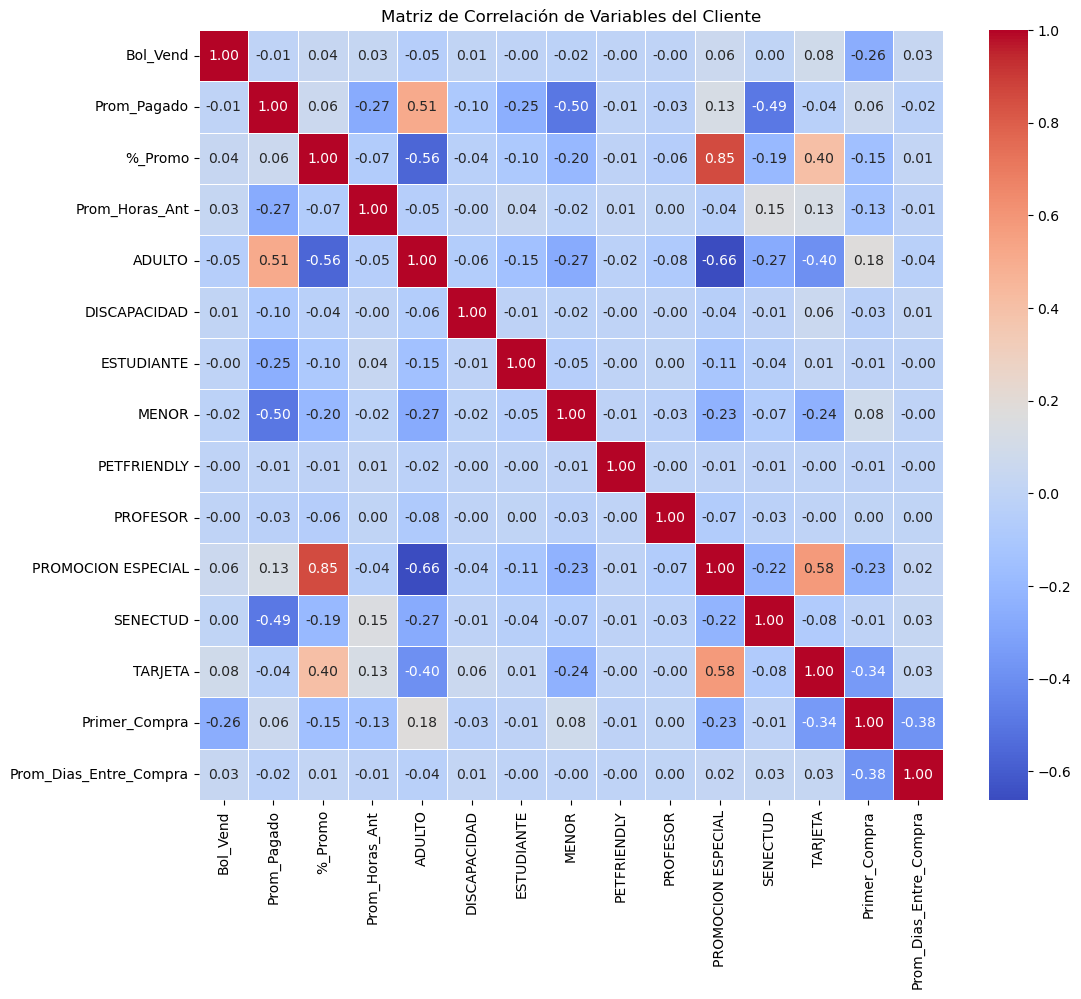

In [21]:
# Calculamos la matriz de correlación
matriz_correlacion = df_correo[df_correo.columns[1:]].corr()

# Generamos un mapa de calor (heatmap) para visualizar
plt.figure(figsize=(12, 10))
sns.heatmap(matriz_correlacion, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Matriz de Correlación de Variables del Cliente')
plt.savefig('matriz_de_correlacion.png', dpi=300, bbox_inches='tight')